# Multi-Label dataset model training

Fine-tune training of the ResNet 50 with data augmentation and fine-tuning 

I am using fastai library, this notebook also includes some exploration into training and reverts, so refer to the summary for the final training procdure

## Summary of the training steps:
-   Start with a standard image size - 256 This is larger than standard image size for ResNet50, but we wanted to get a faster initial tuning of the model to our images.
-   Freeze all but the custom head. We use a custom head that Average + Max concatenates the outputs of the convolutional layers and feeds to two densely connected layers with ReLu activations.
-   Train with a fixed learning rate (lr) for 3 epochs
-   One cycle training policy Set max lr and resume training for 2 more epochs 
-   At this step our validation loss decreases to 0.11 and the mean f1 score is 0.88
-   Increase Image size to 299 We do this to add more detail and tuning of the network
-   Train with one cycle for 2 epochs
-   Decrease Image size to 224 reducing the image size correct any overfitting and stabilizes the model
-   Train with one cycle for 2 epochs with a reduced lr
-   Unfreeze the reset of the layers and train and use differential learning rate for different layers in the network
-   This decrease our loss to 0.08 and increase macro f1 score to 0.90


## Evaluation 

The evaluation metric we used is the Mean F1 score. The F1 score, commonly used in information retrieval, measures accuracy using the statistics precision p and recall r.  Precision is the ratio of true positives (tp) to all predicted positives (tp + fp). Recall is the ratio of true positives to all actual positives (tp + fn). The F1 score is given by:

$F1 = 2\frac{P.R}{P+R}$ where $P = \frac{tp}{tp+fp}, R = \frac{tp}{tp+fn}$


The F1 metric weights recall and precision equally, and a good retrieval algorithm will maximize both precision and recall simultaneously. Thus, moderately good performance on both will be favored over extremely good performance on one and poor performance on the other.

Mean F1 score will be the average F1 score group by classes, giving each class an equal weight (macro - f1).

$Mean F1 = Average(F1_{class=1}, F1_{class=2}, ..... F1_{class=n})$



## Imports

In [1]:
import pandas as pd
from glob import glob
from pathlib import Path
from tqdm import tqdm

path = Path('/home/image_tagging')

/root/anaconda3/envs/pers_d_fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/root/anaconda3/envs/pers_d_fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Data labels preview

In [2]:
gt = pd.read_csv(path/'data/groundtruth_new_20180116_v2.csv')
gt.shape

(41889, 2)

In [3]:
gt.head()

,images_id,labels
0,10013061.jpg,face text
1,10034668.jpg,text
2,10036850.jpg,text
3,10037491.jpg,property
4,10037530.jpg,collaged


In [4]:
train_gt = gt.sample(frac=0.70)

In [5]:
val_gt = gt[~gt.index.isin(train_gt.index)]
train_gt.shape, val_gt.shape

((29322, 2), (12567, 2))

### Train and holdout set prep

Setting aside 30% as holdout set , will be doing train -test split on the remaining 70% for model tuning

In [7]:
train_gt.to_csv(path/'data/groundtruth_new_20180116_v2_train.csv', index=False)
val_gt.to_csv(path/'data/groundtruth_new_20180116_v2_val.csv', index=False)

In [41]:
val_gt = pd.read_csv(path/'data/groundtruth_new_20180116_v2_val.csv')
val_gt.shape

(12567, 2)

## Exp

In [2]:
from fastai.vision import *

In [76]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.2)
# tfms = (tfms[0] + rand_resize_crop(size=256))
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.05), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.45, 0.55)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.9, 1.1111111111111112)}, p=0.75, resolved={}, do_run=True, is_random=True)],
 [RandTransform(tfm=TfmCrop (crop_p

In [80]:
data = ImageList.from_csv(path = path,
                          folder = 'data/moderation_images/small-256',
                          csv_name='data/groundtruth_new_20180116_v2_train.csv').split_by_rand_pct(valid_pct=0.2,seed=1).label_from_df(label_delim=' ').transform(tfms=tfms, size=256).databunch()


In [81]:
holdout = ImageList.from_csv(path = path,
                          folder = 'data/moderation_images/small-256',
                          csv_name='data/groundtruth_new_20180116_v2_val.csv').split_none().label_from_df(label_delim=' ').transform(tfms=[], size=256,resize_method=ResizeMethod.SQUISH).databunch()


In [70]:
type(data.valid_dl), type(holdout.train_dl)

(fastai.basic_data.DeviceDataLoader, fastai.basic_data.DeviceDataLoader)

In [82]:
data.train_ds.y.classes

['collaged', 'face', 'floorplan', 'map', 'property', 'siteplan', 'text']

In [83]:
data.valid_ds.y.c2i

{'collaged': 0,
 'face': 1,
 'floorplan': 2,
 'map': 3,
 'property': 4,
 'siteplan': 5,
 'text': 6}

In [84]:
data.batch_size = 32
print(data.batch_size)

32


### Train - 256

In [85]:
learn = cnn_learner(data=data,
                   base_arch=models.resnet50,
                   pretrained=True,
                   metrics=fbeta
                  )

In [86]:
learn.lr_find(start_lr=1e-07,end_lr=1,num_it=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


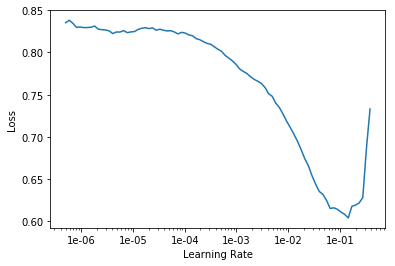

In [87]:
learn.recorder.plot()

In [88]:
learn.fit(3, lr=1e-02)

epoch,train_loss,valid_loss,fbeta,time
0,0.174187,0.198502,0.812061,02:57
1,0.173502,0.163840,0.858567,03:00
2,0.156937,0.145694,0.873941,02:59


In [89]:
learn.fit_one_cycle(cyc_len=2, max_lr=1e-02)

epoch,train_loss,valid_loss,fbeta,time
0,0.158229,0.127337,0.888075,02:57
1,0.129751,0.112652,0.900893,02:59


In [90]:
preds,y = learn.get_preds(DatasetType.Valid, with_loss=False)

In [91]:
learn.data.valid_ds.x

ImageList (5864 items)
Image (3, 256, 362),Image (3, 256, 307),Image (3, 256, 341),Image (3, 256, 384),Image (3, 256, 384)
Path: /home/image_tagging

In [92]:
from sklearn.metrics import f1_score, classification_report
preds_w_thres = [[1.0 if v>=0.5 else 0.0 for v in pred] for pred in preds]
# val_y_ = [[1 if i in pred else 0 for i in range(0,7)] for pred in data.valid_ds.y.items]
val_y_ = y
print(f1_score(np.array(val_y_), np.array(preds_w_thres), average='samples'))
print(classification_report(np.array(val_y_), np.array(preds_w_thres)))

0.8795028584421491
              precision    recall  f1-score   support

           0       0.84      0.66      0.74       497
           1       0.90      0.79      0.84       729
           2       0.97      0.96      0.96       508
           3       0.96      0.86      0.91       335
           4       0.88      0.93      0.90      2231
           5       0.92      0.85      0.88       179
           6       0.92      0.85      0.88      2960

   micro avg       0.90      0.86      0.88      7439
   macro avg       0.91      0.84      0.87      7439
weighted avg       0.90      0.86      0.88      7439
 samples avg       0.90      0.88      0.88      7439



/root/anaconda3/envs/pers_d_fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/envs/pers_d_fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [93]:
learn.fit_one_cycle(cyc_len=2, max_lr=1e-02)

epoch,train_loss,valid_loss,fbeta,time
0,0.152035,0.138315,0.881829,02:58
1,0.130707,0.108255,0.904602,03:00


In [94]:
preds,y = learn.get_preds(DatasetType.Valid, with_loss=False)

In [96]:
from sklearn.metrics import f1_score, classification_report
preds_w_thres = [[1.0 if v>=0.5 else 0.0 for v in pred] for pred in preds]
# val_y_ = [[1 if i in pred else 0 for i in range(0,7)] for pred in data.valid_ds.y.items]
val_y_ = y
print(f1_score(np.array(val_y_), np.array(preds_w_thres), average='samples'))
print(classification_report(np.array(val_y_), np.array(preds_w_thres)))

0.885227051257065
              precision    recall  f1-score   support

           0       0.84      0.71      0.77       497
           1       0.87      0.84      0.86       729
           2       0.96      0.97      0.97       508
           3       0.94      0.89      0.91       335
           4       0.87      0.95      0.91      2231
           5       0.94      0.83      0.88       179
           6       0.93      0.84      0.88      2960

   micro avg       0.90      0.87      0.89      7439
   macro avg       0.91      0.86      0.88      7439
weighted avg       0.90      0.87      0.89      7439
 samples avg       0.90      0.89      0.89      7439



/root/anaconda3/envs/pers_d_fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/envs/pers_d_fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [97]:
learn.save('resnet50a_256_ckpt_1')

In [125]:
torch.save(learn.model.state_dict(), open('../models/resnet50a_256_ckpt_1_sd.model', 'wb'))

### Increase the image size to 299

In [131]:
data_all = ImageList.from_csv(path = path,
                          folder = 'data/moderation_images/all_images',
                          csv_name='data/groundtruth_new_20180116_v2_train.csv').split_by_rand_pct(valid_pct=0.2,seed=1).label_from_df(label_delim=' ').transform(tfms=tfms, size=299).databunch()


In [132]:
data_all.valid_ds.y.c2i

{'collaged': 0,
 'face': 1,
 'floorplan': 2,
 'map': 3,
 'property': 4,
 'siteplan': 5,
 'text': 6}

In [133]:
data_all.batch_size = 32
learn.data = data_all

In [134]:
learn.fit_one_cycle(cyc_len=2, max_lr=1e-02)

epoch,train_loss,valid_loss,fbeta,time
0,0.139476,0.116423,0.898815,08:04
1,0.117179,0.111286,0.913620,07:13


In [135]:
learn.fit_one_cycle(cyc_len=1, max_lr=1e-02)

epoch,train_loss,valid_loss,fbeta,time
0,0.115861,0.100191,0.914752,07:21


In [136]:
preds,y = learn.get_preds(DatasetType.Valid, with_loss=False)
preds_w_thres = [[1.0 if v>=0.5 else 0.0 for v in pred] for pred in preds]
# val_y_ = [[1 if i in pred else 0 for i in range(0,7)] for pred in data.valid_ds.y.items]
val_y_ = y
print(f1_score(np.array(val_y_), np.array(preds_w_thres), average='samples'))
print(classification_report(np.array(val_y_), np.array(preds_w_thres)))

0.8951179107386475
              precision    recall  f1-score   support

           0       0.90      0.67      0.77       497
           1       0.95      0.79      0.86       729
           2       0.95      0.98      0.96       508
           3       0.96      0.88      0.92       335
           4       0.90      0.93      0.91      2231
           5       0.96      0.84      0.90       179
           6       0.92      0.88      0.90      2960

   micro avg       0.92      0.87      0.90      7439
   macro avg       0.93      0.85      0.89      7439
weighted avg       0.92      0.87      0.90      7439
 samples avg       0.91      0.89      0.90      7439



/root/anaconda3/envs/pers_d_fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/envs/pers_d_fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [137]:
learn.fit_one_cycle(cyc_len=1, max_lr=1e-03)

epoch,train_loss,valid_loss,fbeta,time
0,0.116395,0.097752,0.915702,07:08


In [138]:
preds,y = learn.get_preds(DatasetType.Valid, with_loss=False)
preds_w_thres = [[1.0 if v>=0.5 else 0.0 for v in pred] for pred in preds]
val_y_ = y
print(f1_score(np.array(val_y_), np.array(preds_w_thres), average='samples'))
print(classification_report(np.array(val_y_), np.array(preds_w_thres)))

0.8986536087832132
              precision    recall  f1-score   support

           0       0.90      0.66      0.76       497
           1       0.96      0.78      0.86       729
           2       0.97      0.96      0.97       508
           3       0.95      0.88      0.92       335
           4       0.88      0.97      0.92      2231
           5       0.92      0.89      0.90       179
           6       0.95      0.84      0.89      2960

   micro avg       0.92      0.87      0.90      7439
   macro avg       0.93      0.85      0.89      7439
weighted avg       0.93      0.87      0.90      7439
 samples avg       0.92      0.89      0.90      7439



In [143]:
learn.data.valid_dl = holdout.train_dl

In [144]:
preds,y = learn.get_preds(DatasetType.Valid, with_loss=False)
preds_w_thres = [[1.0 if v>=0.5 else 0.0 for v in pred] for pred in preds]
val_y_ = y
print(f1_score(np.array(val_y_), np.array(preds_w_thres), average='samples'))
print(classification_report(np.array(val_y_), np.array(preds_w_thres)))

0.877702487244898
              precision    recall  f1-score   support

           0       0.68      0.77      0.72      1030
           1       0.98      0.84      0.91      1560
           2       0.99      0.95      0.97      1114
           3       0.94      0.87      0.90       664
           4       0.87      0.95      0.91      4890
           5       0.89      0.84      0.86       370
           6       0.94      0.80      0.87      6209

   micro avg       0.90      0.86      0.88     15837
   macro avg       0.90      0.86      0.88     15837
weighted avg       0.91      0.86      0.88     15837
 samples avg       0.89      0.88      0.88     15837



/root/anaconda3/envs/pers_d_fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/envs/pers_d_fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [146]:
data.train_ds.y.c2i

{'collaged': 0,
 'face': 1,
 'floorplan': 2,
 'map': 3,
 'property': 4,
 'siteplan': 5,
 'text': 6}

In [139]:
learn.save('resnet50a_256_ckpt_2')

In [140]:
torch.save(learn.model.state_dict(), open('../models/resnet50a_256_ckpt_2_sd.model', 'wb'))

### Test on Pytorch

The model delveloped using fastai needs to be able to run without it. This is the model for the resnet 50 learner

In [220]:
import torch
from torch import nn
import torchvision.models as models
from time import time

In [221]:
class AdaptiveConcatPool2d(nn.Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, sz=None):
        "Output will be 2*sz or 2 if sz is None"
        super().__init__()
        sz = sz or 1
        self.ap,self.mp = nn.AdaptiveAvgPool2d(sz), nn.AdaptiveMaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

In [222]:
class Flatten(nn.Module):
    "Flatten `x` to a single dimension, often used at the end of a model. `full` for rank-1 tensor"
    def __init__(self, full:bool=False):
        super().__init__()
        self.full = full
    
    def forward(self, x):
        return x.view(-1) if self.full else x.view(x.size(0), -1)

In [223]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        base_model = models.resnet50(pretrained=False)
        base_model = nn.Sequential(*[m for m in base_model.children()][:-2])
        head = nn.Sequential(AdaptiveConcatPool2d(), 
                Flatten(), 
                nn.BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True),
                nn.Dropout(p=0.25),
                nn.Linear(in_features=4096, out_features=512, bias=True),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True),
                nn.Dropout(p=0.5),
                nn.Linear(in_features=512, out_features=7, bias=True))
        self.model = nn.Sequential(base_model, head)

    def forward(self, x):
        x = self.model(x)
        return x   
        
    def load_state_dict(self, *args, **kwargs):
        self.model.load_state_dict(torch.load( *args, **kwargs))
        
    def set_eval(self):
        self.model = self.model.eval()
        
    def to_cpu(self):
        self.model = self.model.cpu()
        
    def predict(self,x):
        start = time()
        x = x.unsqueeze(0)
        out = self.model(*[x])
#         print(f'predicted in {time() - start} secs')
        out = torch.sigmoid(out)
        pred = (out >= 0.5).float()
        return (pred, out) 

In [171]:
model = Model()
model.load_state_dict(f='../models/resnet50a_256_ckpt_2_sd.model', map_location='cpu')
model.set_eval()

### Try using the prediction pipeline code

Check the performance using the same code / image processing step that will be used during prediction

In [148]:
valid_df = pd.read_csv('../data/groundtruth_new_20180116_v2_val.csv')
valid_df.head()

,images_id,labels
0,10034668.jpg,text
1,10038985.jpg,face text collaged
2,10081770.jpg,face text map
3,10084298.jpg,collaged
4,10086384.jpg,text


In [172]:
valid_df.shape

(12567, 2)

In [183]:
imgs_path = Path("data/moderation_images/all_images")

from PIL import Image
from  torchvision import transforms
from fastprogress import master_bar, progress_bar

def predict_image(model, im_path):
    im = Image.open(path/imgs_path/im_path)
    im = im.resize((256,256)).convert('RGB')
    im = transforms.ToTensor()(im)
    pred = model.predict(im)[1] # the confidences
    pred = pred.detach().numpy()[0]
    return pred
    
def predict_evaluate(model, df):
    """
    Predict images in df and evaluate against the true labels in df
    """
    preds = [predict_image(model, im_path) for im_path in progress_bar(df.images_id)] 
    preds_w_thres = [[1.0 if v>=0.5 else 0.0 for v in pred] for pred in preds]
    
    labels_ord = ["collaged", "face", "floorplan", "map", "property", "siteplan", "text"]
    def get_one_hot(l):
        l = l.split(" ")
        return [1.0 if tl in l else 0.0 for tl in labels_ord] 
    val_y = df.labels.map(get_one_hot)
    val_y = [[float(v) for v in t] for t in val_y]
    print(f1_score(np.array(val_y), np.array(preds_w_thres), average='samples'))
    print(classification_report(np.array(val_y), np.array(preds_w_thres)))
    

predict_evaluate(model, valid_df.iloc[0:10])
# Image.open(path/imgs_path/valid_df.iloc[0]['images_id'])

0.9133333333333333
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.50      0.67         2
           2       0.00      0.00      0.00         0
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       0.88      1.00      0.93         7

   micro avg       0.88      0.94      0.91        16
   macro avg       0.81      0.79      0.78        16
weighted avg       0.90      0.94      0.90        16
 samples avg       0.90      0.97      0.91        16



In [185]:
predict_evaluate(model, valid_df)

/root/anaconda3/envs/pers_d_fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19660800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/root/anaconda3/envs/pers_d_fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


0.8734360968068298
              precision    recall  f1-score   support

           0       0.68      0.78      0.73      1031
           1       0.97      0.86      0.91      1560
           2       0.99      0.93      0.96      1116
           3       0.95      0.87      0.91       666
           4       0.85      0.98      0.91      4900
           5       0.86      0.86      0.86       370
           6       0.97      0.76      0.86      6220

   micro avg       0.90      0.86      0.88     15863
   macro avg       0.90      0.86      0.88     15863
weighted avg       0.91      0.86      0.88     15863
 samples avg       0.89      0.87      0.87     15863



/root/anaconda3/envs/pers_d_fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/envs/pers_d_fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


### Try training some more on 299

Increase the image size and continue training

In [186]:
data_all = ImageList.from_csv(path = path,
                          folder = 'data/moderation_images/all_images',
                          csv_name='data/groundtruth_new_20180116_v2_train.csv').split_by_rand_pct(valid_pct=0.2,seed=1).label_from_df(label_delim=' ').transform(tfms=tfms, size=299).databunch()
data_all.batch_size = 32



In [187]:
learn = cnn_learner(data=data_all,
                   base_arch=models.resnet50,
                   pretrained=True,
                   metrics=fbeta
                  )

In [ ]:
learn.load('resnet50a_256_ckpt_2')

In [189]:
learn.fit_one_cycle(cyc_len=1, max_lr=1e-03)

epoch,train_loss,valid_loss,fbeta,time
0,0.110939,0.094171,0.916318,07:00


In [190]:
learn.fit_one_cycle(cyc_len=2, max_lr=1e-03)

epoch,train_loss,valid_loss,fbeta,time
0,0.107762,0.093482,0.919262,07:05
1,0.105855,0.091905,0.920877,07:05


In [191]:
preds,y = learn.get_preds(DatasetType.Valid, with_loss=False)
preds_w_thres = [[1.0 if v>=0.5 else 0.0 for v in pred] for pred in preds]
val_y_ = y
print(f1_score(np.array(val_y_), np.array(preds_w_thres), average='samples'))
print(classification_report(np.array(val_y_), np.array(preds_w_thres)))

0.9038402195803288
              precision    recall  f1-score   support

           0       0.86      0.73      0.79       497
           1       0.92      0.84      0.88       729
           2       0.97      0.97      0.97       508
           3       0.97      0.89      0.93       335
           4       0.90      0.94      0.92      2231
           5       0.91      0.89      0.90       179
           6       0.93      0.88      0.91      2960

   micro avg       0.92      0.89      0.91      7439
   macro avg       0.92      0.88      0.90      7439
weighted avg       0.92      0.89      0.91      7439
 samples avg       0.92      0.90      0.90      7439



/root/anaconda3/envs/pers_d_fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/envs/pers_d_fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [192]:
learn.save('resnet50a_256_ckpt_3')

In [193]:
torch.save(learn.model.state_dict(), open('../models/resnet50a_256_ckpt_3_sd.model', 'wb'))

In [194]:
learn.fit_one_cycle(cyc_len=2, max_lr=1e-03)

epoch,train_loss,valid_loss,fbeta,time
0,0.104993,0.090865,0.923354,06:59
1,0.103737,0.090556,0.924214,06:57


In [195]:
preds,y = learn.get_preds(DatasetType.Valid, with_loss=False)
preds_w_thres = [[1.0 if v>=0.5 else 0.0 for v in pred] for pred in preds]
val_y_ = y
print(f1_score(np.array(val_y_), np.array(preds_w_thres), average='samples'))
print(classification_report(np.array(val_y_), np.array(preds_w_thres)))

0.9069041122588191
              precision    recall  f1-score   support

           0       0.88      0.71      0.78       497
           1       0.94      0.84      0.89       729
           2       0.97      0.97      0.97       508
           3       0.96      0.89      0.93       335
           4       0.90      0.95      0.93      2231
           5       0.91      0.89      0.90       179
           6       0.94      0.87      0.91      2960

   micro avg       0.92      0.89      0.91      7439
   macro avg       0.93      0.88      0.90      7439
weighted avg       0.93      0.89      0.91      7439
 samples avg       0.92      0.91      0.91      7439



In [196]:
learn.save('resnet50a_256_ckpt_4')

In [197]:
torch.save(learn.model.state_dict(), open('../models/resnet50a_256_ckpt_4_sd.model', 'wb'))

### Reduce size to 224

In [198]:
data_all = ImageList.from_csv(path = path,
                          folder = 'data/moderation_images/all_images',
                          csv_name='data/groundtruth_new_20180116_v2_train.csv').split_by_rand_pct(valid_pct=0.2,seed=1).label_from_df(label_delim=' ').transform(tfms=tfms, size=224).databunch()
data_all.batch_size = 32


In [199]:
learn.data = data_all

In [200]:
learn.fit_one_cycle(cyc_len=2, max_lr=1e-03)

epoch,train_loss,valid_loss,fbeta,time
0,0.122762,0.101116,0.912228,06:19
1,0.110876,0.098952,0.915111,06:18


Reverting to previous checkpoint since reducing size to 224 worsens the result

### Unfreeze and train on checkpoint 4

Fine tune the resnet layers. Use differntial lerning rate for different sections

In [201]:
data_all = ImageList.from_csv(path = path,
                          folder = 'data/moderation_images/all_images',
                          csv_name='data/groundtruth_new_20180116_v2_train.csv').split_by_rand_pct(valid_pct=0.2,seed=1).label_from_df(label_delim=' ').transform(tfms=tfms, size=299).databunch()
data_all.batch_size = 32


In [202]:
learn = cnn_learner(data=data_all,
                   base_arch=models.resnet50,
                   pretrained=True,
                   metrics=fbeta
                  )

In [ ]:
learn.load('resnet50a_256_ckpt_4')

In [204]:
learn.unfreeze()

In [205]:
lr=np.array([1e-5,1e-4,1e-3])
learn.fit_one_cycle(cyc_len=2, max_lr=lr)

epoch,train_loss,valid_loss,fbeta,time
0,0.112379,0.103342,0.917997,07:13
1,0.105180,0.088884,0.924960,07:20


In [206]:
preds,y = learn.get_preds(DatasetType.Valid, with_loss=False)
preds_w_thres = [[1.0 if v>=0.5 else 0.0 for v in pred] for pred in preds]
val_y_ = y
print(f1_score(np.array(val_y_), np.array(preds_w_thres), average='samples'))
print(classification_report(np.array(val_y_), np.array(preds_w_thres)))

0.9089821672188657
              precision    recall  f1-score   support

           0       0.88      0.72      0.79       497
           1       0.95      0.82      0.88       729
           2       0.96      0.98      0.97       508
           3       0.96      0.90      0.93       335
           4       0.89      0.96      0.93      2231
           5       0.94      0.85      0.89       179
           6       0.95      0.87      0.91      2960

   micro avg       0.93      0.89      0.91      7439
   macro avg       0.93      0.87      0.90      7439
weighted avg       0.93      0.89      0.91      7439
 samples avg       0.92      0.91      0.91      7439



/root/anaconda3/envs/pers_d_fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/envs/pers_d_fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [207]:
learn.save('resnet50a_256_ckpt_5')

In [208]:
torch.save(learn.model.state_dict(), open('../models/resnet50a_256_ckpt_5_sd.model', 'wb'))

Freeze the resnet layers and train the last layers some more

In [209]:
learn.freeze()

In [210]:
learn.fit_one_cycle(cyc_len=2, max_lr=1e-03)

epoch,train_loss,valid_loss,fbeta,time
0,0.098945,0.090557,0.923552,07:03
1,0.103595,0.088427,0.926253,06:56


In [211]:
learn.save('resnet50a_256_ckpt_6')

In [212]:
torch.save(learn.model.state_dict(), open('../models/resnet50a_256_ckpt_6_sd.model', 'wb'))

In [213]:
preds,y = learn.get_preds(DatasetType.Valid, with_loss=False)
preds_w_thres = [[1.0 if v>=0.5 else 0.0 for v in pred] for pred in preds]
val_y_ = y
print(f1_score(np.array(val_y_), np.array(preds_w_thres), average='samples'))
print(classification_report(np.array(val_y_), np.array(preds_w_thres)))

0.9058102709023582
              precision    recall  f1-score   support

           0       0.89      0.73      0.80       497
           1       0.95      0.83      0.88       729
           2       0.97      0.97      0.97       508
           3       0.96      0.90      0.93       335
           4       0.89      0.96      0.92      2231
           5       0.93      0.87      0.90       179
           6       0.96      0.86      0.90      2960

   micro avg       0.93      0.89      0.91      7439
   macro avg       0.93      0.87      0.90      7439
weighted avg       0.93      0.89      0.91      7439
 samples avg       0.92      0.90      0.91      7439



In [217]:
holdout = ImageList.from_csv(path = path,
                          folder = 'data/moderation_images/all_images',
                          csv_name='data/groundtruth_new_20180116_v2_val.csv').split_none().label_from_df(label_delim=' ').transform(tfms=[], size=299,resize_method=ResizeMethod.SQUISH).databunch()


In [218]:
learn.data.valid_dl = holdout.train_dl

In [219]:
preds,y = learn.get_preds(DatasetType.Valid, with_loss=False)
preds_w_thres = [[1.0 if v>=0.5 else 0.0 for v in pred] for pred in preds]
val_y_ = y
print(f1_score(np.array(val_y_), np.array(preds_w_thres), average='samples'))
print(classification_report(np.array(val_y_), np.array(preds_w_thres)))

0.9184146091472304
              precision    recall  f1-score   support

           0       0.79      0.73      0.76      1030
           1       0.95      0.92      0.93      1557
           2       0.99      0.97      0.98      1115
           3       0.95      0.91      0.93       664
           4       0.91      0.97      0.94      4893
           5       0.92      0.83      0.87       367
           6       0.96      0.87      0.91      6208

   micro avg       0.93      0.91      0.92     15834
   macro avg       0.93      0.89      0.90     15834
weighted avg       0.93      0.91      0.92     15834
 samples avg       0.93      0.92      0.92     15834



/root/anaconda3/envs/pers_d_fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/envs/pers_d_fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


### Check on the prediction pipeline code

In [224]:
model = Model()
model.load_state_dict(f='../models/resnet50a_256_ckpt_6_sd.model', map_location='cpu')
model.set_eval()

In [225]:
valid_df = pd.read_csv('../data/groundtruth_new_20180116_v2_val.csv')
valid_df.head()

,images_id,labels
0,10034668.jpg,text
1,10038985.jpg,face text collaged
2,10081770.jpg,face text map
3,10084298.jpg,collaged
4,10086384.jpg,text


In [226]:
valid_df.shape

(12567, 2)

In [229]:
imgs_path = Path("data/moderation_images/all_images")

from PIL import Image
from  torchvision import transforms
from fastprogress import master_bar, progress_bar

def predict_image(model, im_path):
    im = Image.open(path/imgs_path/im_path)
    im = im.resize((299,299)).convert('RGB')
    im = transforms.ToTensor()(im)
    pred = model.predict(im)[1] # the confidences
    pred = pred.detach().numpy()[0]
    return pred
    
def predict_evaluate(model, df):
    """
    Predict images in df and evaluate against the true labels in df
    """
    preds = [predict_image(model, im_path) for im_path in progress_bar(df.images_id)] 
    preds_w_thres = [[1.0 if v>=0.5 else 0.0 for v in pred] for pred in preds]
    
    labels_ord = ["collaged", "face", "floorplan", "map", "property", "siteplan", "text"]
    def get_one_hot(l):
        l = l.split(" ")
        return [1.0 if tl in l else 0.0 for tl in labels_ord] 
    val_y = df.labels.map(get_one_hot)
    val_y = [[float(v) for v in t] for t in val_y]
    print(f1_score(np.array(val_y), np.array(preds_w_thres), average='samples'))
    print(classification_report(np.array(val_y), np.array(preds_w_thres)))
    

predict_evaluate(model, valid_df.iloc[0:10])
# Image.open(path/imgs_path/valid_df.iloc[0]['images_id'])

0.9333333333333332
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      1.00      1.00         2
           2       0.00      0.00      0.00         0
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       0.88      1.00      0.93         7

   micro avg       0.89      1.00      0.94        16
   macro avg       0.81      0.86      0.83        16
weighted avg       0.90      1.00      0.94        16
 samples avg       0.90      1.00      0.93        16



In [230]:
predict_evaluate(model, valid_df)

/root/anaconda3/envs/pers_d_fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19660800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/root/anaconda3/envs/pers_d_fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


0.9135269242574088
              precision    recall  f1-score   support

           0       0.78      0.73      0.76      1031
           1       0.95      0.91      0.93      1560
           2       0.99      0.97      0.98      1116
           3       0.96      0.90      0.92       666
           4       0.90      0.97      0.94      4900
           5       0.93      0.83      0.88       370
           6       0.96      0.86      0.91      6220

   micro avg       0.93      0.90      0.91     15863
   macro avg       0.92      0.88      0.90     15863
weighted avg       0.93      0.90      0.91     15863
 samples avg       0.93      0.91      0.91     15863



In [231]:
data_all.train_ds.y.c2i

{'collaged': 0,
 'face': 1,
 'floorplan': 2,
 'map': 3,
 'property': 4,
 'siteplan': 5,
 'text': 6}

## Precision Recall curve

In [232]:
def predict_evaluate(model, df):
    """
    Predict images in df and evaluate against the true labels in df
    """
    preds = [predict_image(model, im_path) for im_path in progress_bar(df.images_id)] 
    preds_w_thres = [[1.0 if v>=0.5 else 0.0 for v in pred] for pred in preds]
    
    labels_ord = ["collaged", "face", "floorplan", "map", "property", "siteplan", "text"]
    def get_one_hot(l):
        l = l.split(" ")
        return [1.0 if tl in l else 0.0 for tl in labels_ord] 
    val_y = df.labels.map(get_one_hot)
    val_y = [[float(v) for v in t] for t in val_y]
    print(f1_score(np.array(val_y), np.array(preds_w_thres), average='samples'))
    print(classification_report(np.array(val_y), np.array(preds_w_thres)))
    return preds
    

In [ ]:
holdout_preds = predict_evaluate(model, valid_df)

In [267]:
from sklearn.metrics import precision_recall_curve
def pr_threshold(label, y_true, y_scores):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores vs threshold (class = %s)" % (label))

    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    pd.Series(thresholds).plot(kind='hist',secondary_y=True)
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    
    i = np.arange(len(thresholds)) 
    precisions = precisions[:-1]
    recalls = recalls[:-1]
    pr = pd.DataFrame({'f1' : pd.Series(2 * (precisions * recalls) / (precisions + recalls), index=i), 'threshold' : pd.Series(thresholds, index=i)})
    pr_t = pr.iloc[(pr.f1-0).abs().argsort()[::-1][:1]]
    
    return list(pr_t['threshold'])[0]

def generate_pr_curve(preds, df, label='collaged'):
    c2i = {'collaged': 0,
             'face': 1,
             'floorplan': 2,
             'map': 3,
             'property': 4,
             'siteplan': 5,
             'text': 6}
    i2c = {v:k for k,v in c2i.items()}
    preds_l = [pred[c2i[label]] for pred in preds]
    y_true = df.labels.map(lambda x: 1 if label in x.split() else 0)
    return pr_threshold(label, y_true, preds_l)

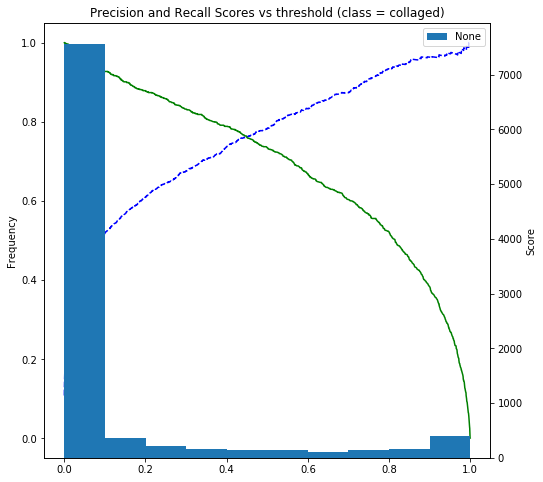

In [268]:
th = generate_pr_curve(holdout_preds, valid_df.copy(), label='collaged')

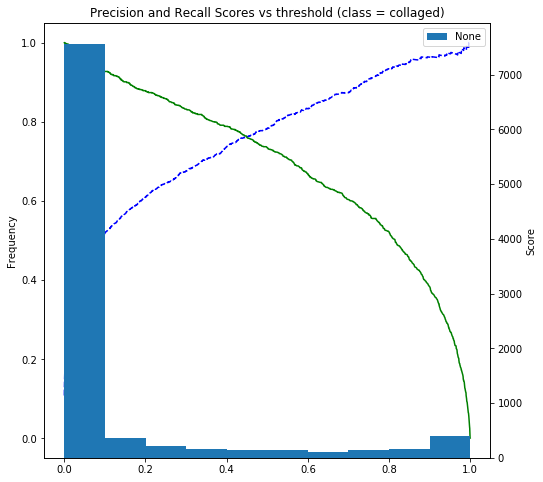

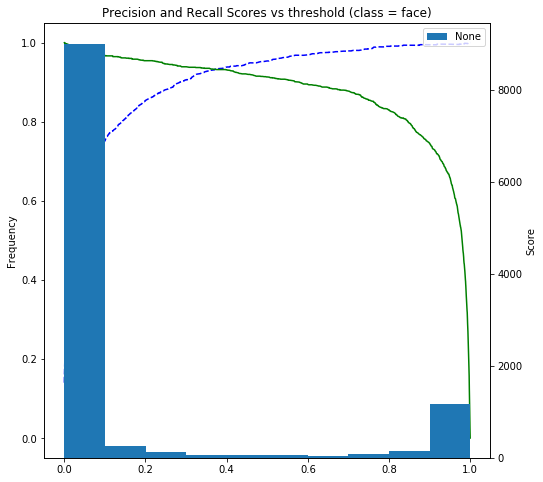

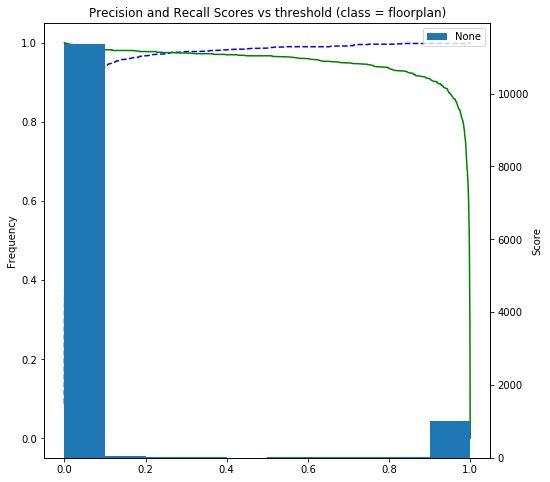

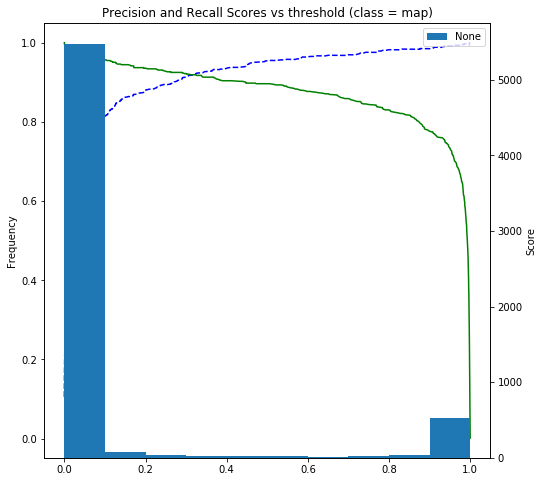

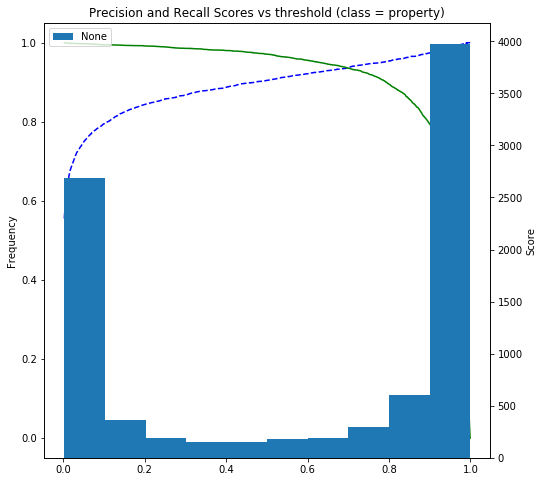

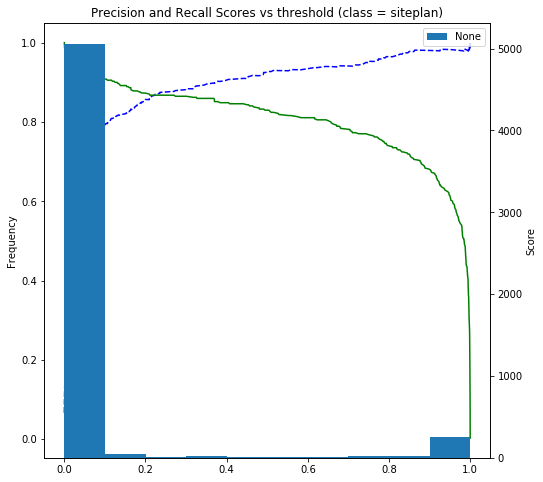

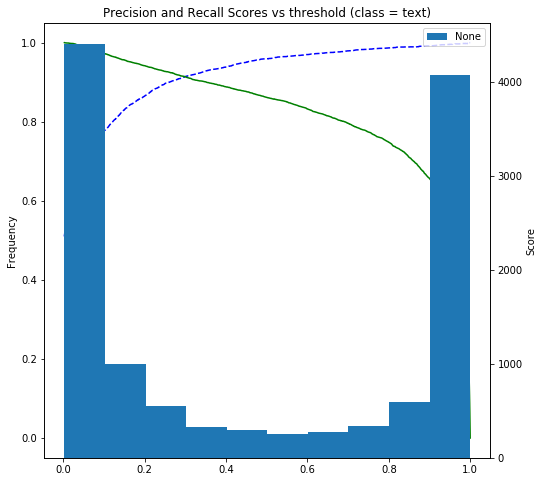

In [269]:
threshs = [generate_pr_curve(holdout_preds, valid_df.copy(), label=label) for label in data_all.train_ds.y.c2i.keys()]

In [245]:
threshs

[0.43360719084739685,
 0.3979600667953491,
 0.5112483501434326,
 0.5055694580078125,
 0.6115564703941345,
 0.3685322105884552,
 0.35070785880088806]

In [246]:
data_all.train_ds.y.c2i

{'collaged': 0,
 'face': 1,
 'floorplan': 2,
 'map': 3,
 'property': 4,
 'siteplan': 5,
 'text': 6}

In [288]:
thresholds = {'face': [0.39, 0.5],
              'property': [0.5, 0.6],
              'text': [0.35, 0.4],
              'floorplan': [0.50, 0.50],
              'siteplan': [0.36, 0.55],
              'collaged': [0.43, 0.7],
              'map': [0.5, 0.6]
              }

### Evaluate performance by threshold min

In [272]:
def get_pred_by_thresh(pred):
    c2i = {'collaged': 0,
             'face': 1,
             'floorplan': 2,
             'map': 3,
             'property': 4,
             'siteplan': 5,
             'text': 6}
    i2c = {v:k for k,v in c2i.items()}
    return [1 if v > thresholds[i2c[i]][0] else 0 for i,v in enumerate(pred)]

In [287]:
preds_w_thres = [get_pred_by_thresh(pred) for pred in holdout_preds]

labels_ord = ["collaged", "face", "floorplan", "map", "property", "siteplan", "text"]
def get_one_hot(l):
    l = l.split(" ")
    return [1.0 if tl in l else 0.0 for tl in labels_ord] 
val_y = valid_df.labels.map(get_one_hot)
val_y = [[float(v) for v in t] for t in val_y]

print(f1_score(np.array(val_y), np.array(preds_w_thres), average='samples'))
print(classification_report(np.array(val_y), np.array(preds_w_thres)))

0.9209238481737885
              precision    recall  f1-score   support

           0       0.76      0.77      0.77      1031
           1       0.94      0.93      0.93      1560
           2       0.99      0.97      0.98      1116
           3       0.96      0.90      0.92       666
           4       0.90      0.97      0.94      4900
           5       0.90      0.86      0.88       370
           6       0.93      0.90      0.91      6220

   micro avg       0.91      0.92      0.92     15863
   macro avg       0.91      0.90      0.90     15863
weighted avg       0.92      0.92      0.92     15863
 samples avg       0.92      0.93      0.92     15863

